# Synthetic Lesions added to TDT Pipeline

## GOAL 
The goal is to have a user give the following requirements:
- Region for lesion : str
- number of lesions : int
- radius of lesions : list ( note: should match number of lesions)

Then taking the Patient CT and Mask of region, it will find centres of lesions based on parameters chosen. Then spherical lesions will be created in that region using the radius's given. Constraints: 
- centres cant be outside of region of interest 
- centres + radius extruded cant be overlapping other centres+ radius extruded
- centres + radius extruded cant fall outside of region of interest

then once the centres are found correctly, a new mask will be made with labels assigned corresponding to the TDT pipeline + lesion label (all the lesions are all part of same region). This will be used later for the PBPK model to apply a tumor activity that will be evenly distributed across all the lesions

### Probability Map

This can be multiple choices:
1) Gaussian distribution with centre roughly at centre of roi and std set by user
2) Completely Uniform Probability across ROI 
3)  Use Tumor Occurance Map (taken from real patient data)
4) User Defined Centres

### User Inputs

In [ ]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from totalsegmentator.python_api import totalsegmentator
from torch.cuda.amp import GradScaler as _GradScaler
import torch
torch.GradScaler = _GradScaler

# -----------------------------
# USER INPUTS
# -----------------------------
# Expected to exist
output_dir = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/testing_synthetic_lesions'
os.makedirs(output_dir, exist_ok=True)
patient_ct_dicom_dir = os.path.join(output_dir, 'ct_dicom') # user gave


# lesion requirements (per ROI)
lesion_specs = {
    "liver": {
        "n_lesions": 5,
        "radii_mm": [5, 10, 15, 15, 15],
        "prob": "gaussian",     # "uniform", "gaussian", "TOM", "user_defined"
        "sigma_mm": 60.0,       # only used if prob="gaussian"
        "margin_mm": 1.0,       # extra safety margin for boundary + overlap unit (mm)
        "seed": 0, # random seed for reproducibility (only affects "uniform" and "gaussian" prob models)
    },
    "heart": {
        "n_lesions": 3,
        "radii_mm": [5, 15, 15],
        "prob": "uniform", 
        "sigma_mm": 40.0, 
        "margin_mm": 1.0, 
        "seed": 1, 
    },
}


# sanity checks
for roi, spec in lesion_specs.items():
    assert spec["n_lesions"] == len(spec["radii_mm"]), f"{roi}: n_lesions must match radii_mm length"


#### Create Masks using Total Seg 

In [36]:
patient_ct_nii_path = os.path.join(output_dir, 'ct.nii.gz')
masks_dir = os.path.join(output_dir, 'masks')  # contains liver.nii.gz etc.
#change dicom to a nii file 
def dicom_to_nifti(dicom_dir, output_path): 
    reader = sitk.ImageSeriesReader() 
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir) 
    reader.SetFileNames(dicom_names) 
    image = reader.Execute() 
    sitk.WriteImage(image, output_path) 
if not os.path.exists(patient_ct_nii_path):
    dicom_to_nifti(patient_ct_dicom_dir, patient_ct_nii_path)

create_masks = True
if create_masks:
    if not os.path.exists(masks_dir): 
        os.makedirs(masks_dir)
    roi = lesion_specs.keys()
    for r in roi: 
        roi = [r]
        print(f'Running TotalSegmentator for {r}...') 
        if not os.path.exists(os.path.join(masks_dir, f"{r}.nii.gz")):
            totalsegmentator(patient_ct_nii_path, 
                            output=masks_dir, 
                            fast = True, 
                            task = 'total', 
                            roi_subset = roi) 
        print("output saved to: ", os.path.join(masks_dir, f"{r}.nii.gz"))

Running TotalSegmentator for liver...
output saved to:  /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/testing_synthetic_lesions/masks/liver.nii.gz
Running TotalSegmentator for heart...
output saved to:  /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/testing_synthetic_lesions/masks/heart.nii.gz


#### Helpers

In [37]:
def sitk_to_np(img: sitk.Image) -> np.ndarray:
    # SimpleITK -> numpy array in (z, y, x)
    return sitk.GetArrayFromImage(img)

def np_to_sitk(arr_zyx: np.ndarray, ref: sitk.Image, pixel_id=sitk.sitkInt16) -> sitk.Image:
    out = sitk.GetImageFromArray(arr_zyx)
    out.SetSpacing(ref.GetSpacing())
    out.SetOrigin(ref.GetOrigin())
    out.SetDirection(ref.GetDirection())
    out = sitk.Cast(out, pixel_id)
    return out

def spacing_zyx_from_sitk(img: sitk.Image) -> np.ndarray:
    # SITK spacing is (x, y, z); numpy array order is (z, y, x)
    sx, sy, sz = img.GetSpacing()
    return np.array([sz, sy, sx], dtype=np.float64)

def phys_dist_mm(idx1_zyx, idx2_zyx, spacing_zyx) -> float:
    d = (np.array(idx1_zyx, dtype=np.float64) - np.array(idx2_zyx, dtype=np.float64)) * spacing_zyx
    return float(np.sqrt(np.sum(d*d)))

#### Load CT + quick view

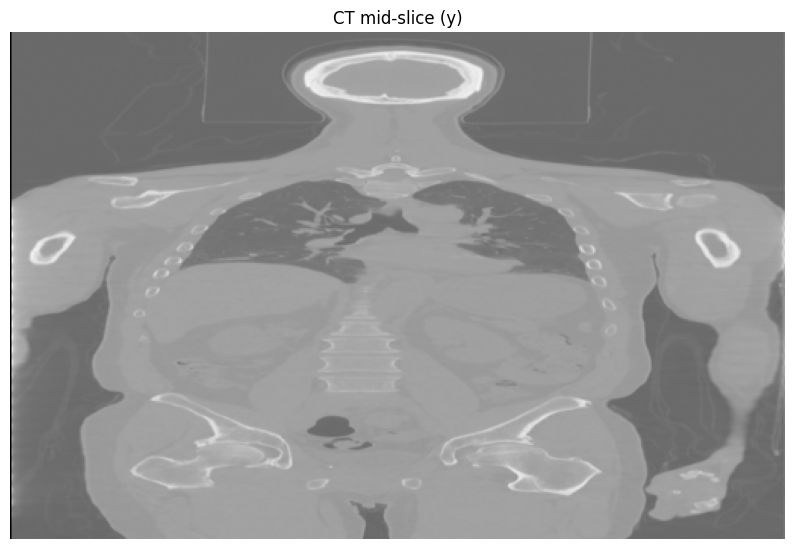

In [38]:
ct_img = sitk.ReadImage(patient_ct_nii_path)
ct = sitk_to_np(ct_img).astype(np.float32)  # (z,y,x)

mid_y = ct.shape[1] // 2
plt.figure(figsize=(10,8))
plt.imshow(ct[:, mid_y, :][::-1], cmap="gray")
plt.title("CT mid-slice (y)")
plt.axis("off")
plt.show()


#### Load ROI masks + show overlays

[False  True]


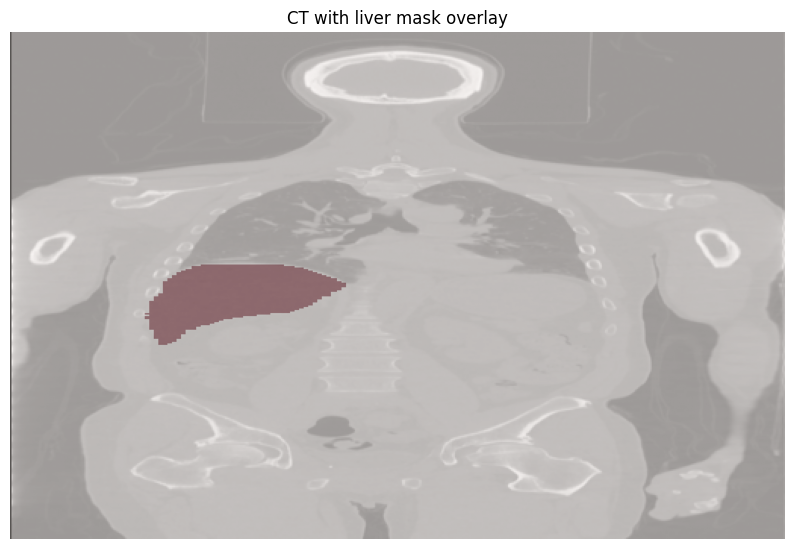

[False  True]


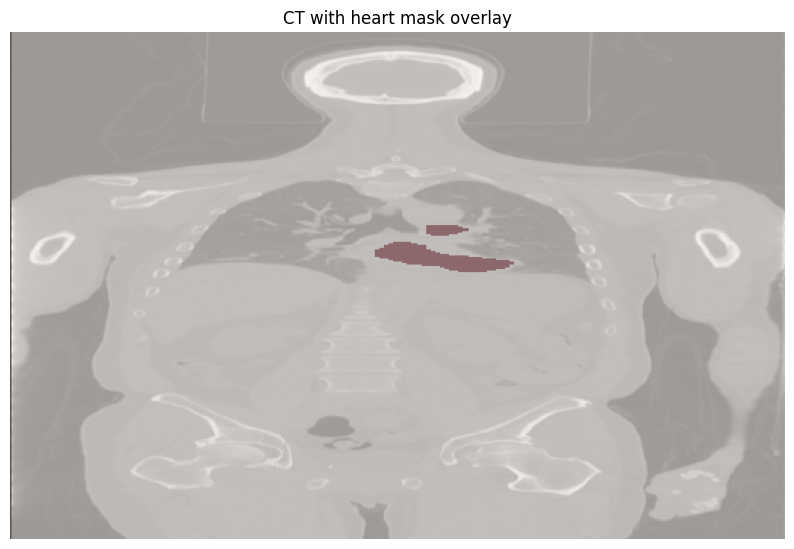

In [39]:
def load_roi_mask(roi_name: str) -> tuple[sitk.Image, np.ndarray]:
    p = os.path.join(masks_dir, f"{roi_name}.nii.gz")
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing ROI mask: {p}")
    m_img = sitk.ReadImage(p)
    m = sitk_to_np(m_img) > 0 # binary mask in (z,y,x) arr
    return m_img, m 

for roi in lesion_specs.keys():
    m_img, m = load_roi_mask(roi)
    mid_y = ct.shape[1] // 2

    print(np.unique(m))
    plt.figure(figsize=(10,8))
    plt.imshow(ct[:, mid_y, :][::-1], cmap="gray")
    plt.imshow(m[:, mid_y, :][::-1], cmap="Reds", alpha=0.35)
    plt.title(f"CT with {roi} mask overlay")
    plt.axis("off")
    plt.show()

#### Tumor Occurance Map - View

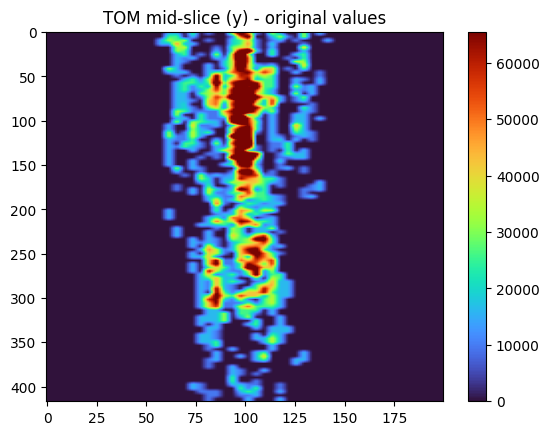

In [40]:
TOM_DICOM = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/data/lesions/TOM_DICOM_modified'

tom_dicom_nii = os.path.join(output_dir, 'tom.nii.gz')
if not os.path.exists(tom_dicom_nii):
    dicom_to_nifti(TOM_DICOM, tom_dicom_nii)
    
tom_img = sitk.ReadImage(tom_dicom_nii)
tom = sitk_to_np(tom_img)

plt.imshow(tom[:, tom.shape[1]//2, :], cmap="turbo",aspect='auto')
plt.title("TOM mid-slice (y) - original values")
plt.colorbar()
plt.show()


#### TOM Registration to CT image + View

#### Probability weights (uniform / gaussian / TOM / user-defined stub)

In [41]:
def candidate_weights(mask: np.ndarray,
                      cand_zyx: np.ndarray,
                      spacing_zyx: np.ndarray,
                      prob: str,
                      sigma_mm: float | None = None,
                      tom_map: np.ndarray | None = None) -> np.ndarray:
    """
    Returns positive weights for each candidate voxel in cand_zyx.
    """
    prob = prob.lower()
    n = cand_zyx.shape[0]

    if prob == "uniform":
        return np.ones(n, dtype=np.float64) # uniform weights

    if prob == "gaussian":
        if sigma_mm is None:
            raise ValueError("sigma_mm required for gaussian")
        # ROI centroid in voxel coords (z,y,x)
        roi_pts = np.argwhere(mask)
        mu = roi_pts.mean(axis=0) # (z,y,x) centroid in voxel coordinates
        # physical distance from centroid for each candidate voxel
        dz = (cand_zyx[:, 0] - mu[0]) * spacing_zyx[0] # length n array of physical z distance from centroid in mm
        dy = (cand_zyx[:, 1] - mu[1]) * spacing_zyx[1] # length n array of physical y distance from centroid in mm
        dx = (cand_zyx[:, 2] - mu[2]) * spacing_zyx[2] # length n array of physical x distance from centroid in mm
        r2 = dx*dx + dy*dy + dz*dz # distance squared in mm^2 (distance from centroid) 
        w = np.exp(-0.5 * r2 / (sigma_mm**2)) # Gaussian weight based on distance from centroid; higher near centroid, lower farther away
        return w.astype(np.float64)

    if prob == "tom":
        if tom_map is None:
            raise ValueError("TOM chosen but tom_map=None. Provide a 3D TOM array aligned to mask.")
        w = tom_map[cand_zyx[:,0], cand_zyx[:,1], cand_zyx[:,2]].astype(np.float64)
        w[w < 0] = 0
        return w + 1e-12 # avoid exact zeros

    if prob == "user_defined":
        # sampling not used; you will pass centers directly
        return np.ones(n, dtype=np.float64)

    raise ValueError(f"Unknown prob choice: {prob}")

#### Core placement algorithm (all constraints enforced)

In [42]:
def place_lesion_centers(mask: np.ndarray,
                         radii_mm: list[float],
                         spacing_zyx: np.ndarray,
                         prob: str = "uniform",
                         sigma_mm: float | None = None,
                         margin_mm: float = 1.0,
                         seed: int = 0,
                         max_attempts_per_lesion: int = 4000,
                         tom_map: np.ndarray | None = None,
                         user_centers_zyx: list[tuple[int,int,int]] | None = None):
    """
    Returns:
      centers_zyx: list of (z,y,x) ints
      radii_mm:    list of radii (same order)
      dist_mm:     distance-to-boundary map (mm) inside ROI
    """
    rng = np.random.default_rng(seed) # seed is for reproducibility of lesion placement, set seed = None for random placement each time

    # Distance transform in mm: for voxels inside ROI, gives distance to nearest outside voxel for every voxel inside ROI
    dist_mm = distance_transform_edt(mask.astype(np.uint8), sampling=spacing_zyx) 

    centers_zyx = [] # list of (z,y,x) lesion centers
    placed_r = [] # radii of placed lesions, same order as centers_zyx

    prob = prob.lower()

    # If user-defined centers: validate and skip sampling
    if prob == "user_defined":
        if user_centers_zyx is None:
            raise ValueError("prob='user_defined' but user_centers_zyx=None")

        if len(user_centers_zyx) != len(radii_mm):
            raise ValueError("user_centers_zyx length must match radii_mm length")

        for c, r in zip(user_centers_zyx, radii_mm):
            c = tuple(map(int, c))
            if not mask[c]:
                raise ValueError(f"User center {c} not inside ROI")
            if dist_mm[c] < (r + margin_mm):
                raise ValueError(f"User center {c} too close to ROI boundary for radius {r} mm")
            for cj, rj in zip(centers_zyx, placed_r):
                if phys_dist_mm(c, cj, spacing_zyx) < (r + rj + margin_mm):
                    raise ValueError(f"User center {c} overlaps existing lesion at {cj}")
            centers_zyx.append(c)
            placed_r.append(r)

        return centers_zyx, placed_r, dist_mm

    # Otherwise: sample lesions sequentially
    # Order matters. 
    # If you place small ones first, you may “block” the ability to place big ones later.
    # Often it’s better to place largest → smallest.
    for i, r in enumerate(radii_mm, start=1): 
        # Candidate voxels: must be inside ROI and far enough from boundary
        cand_mask = dist_mm >= (r + margin_mm)
        cand = np.argwhere(cand_mask) # (n, 3) array of (z,y,x) candidate voxel indices that are valid centers for current lesion radius

        if cand.shape[0] == 0:
            raise RuntimeError(f"No valid candidate centers for radius={r} mm. Try smaller radius or smaller margin.")

        w = candidate_weights(mask, cand, spacing_zyx, prob, sigma_mm=sigma_mm, tom_map=tom_map)
        w = np.maximum(w, 0) # ensure non-negative weights
        w_sum = w.sum() # sum of weights for normalization; if zero, means all candidates have zero weight which is an error
        if w_sum <= 0:
            raise RuntimeError("All candidate weights are zero. Check probability map / gaussian sigma.")
        p = w / w_sum # probability distribution for sampling candidate centers, prob = w / sum of w; higher weight means higher chance of being selected as lesion center

        placed = False
        for attempt in range(max_attempts_per_lesion): # try up to max_attempts_per_lesion times to place this lesion
            k = rng.choice(cand.shape[0], p=p)
            c = tuple(map(int, cand[k]))

            # overlap constraint
            ok = True
            for cj, rj in zip(centers_zyx, placed_r):
                if phys_dist_mm(c, cj, spacing_zyx) < (r + rj + margin_mm):
                    ok = False
                    break

            if ok:
                centers_zyx.append(c)
                placed_r.append(r)
                placed = True
                break

        if not placed:
            raise RuntimeError(
                f"Failed to place lesion {i}/{len(radii_mm)} (r={r}mm) after {max_attempts_per_lesion} attempts. "
                f"Try reducing radii, margin_mm, or switching prob to 'uniform'."
            )

    return centers_zyx, placed_r, dist_mm



#### Build the spherical lesion label-map (multi-label + binary)

In [43]:
def build_lesion_labelmap(mask: np.ndarray,
                          centers_zyx: list[tuple[int,int,int]],
                          radii_mm: list[float],
                          spacing_zyx: np.ndarray) -> np.ndarray:
    """
    Returns int16 label map (z,y,x):
      0 = background
      1..N = lesion id
    """
    Z, Y, X = mask.shape
    labels = np.zeros((Z, Y, X), dtype=np.int16)

    for lbl, (c, r) in enumerate(zip(centers_zyx, radii_mm), start=1):
        z0, y0, x0 = c # centre of lesion in voxel coordinates (z,y,x)
        # compute voxel radius in each dimension, rounding up to ensure we cover the entire physical radius
        rz = int(np.ceil(r / spacing_zyx[0]))  # number of voxels in z direction to cover radius r mm
        ry = int(np.ceil(r / spacing_zyx[1])) # number of voxels in y direction to cover radius r mm
        rx = int(np.ceil(r / spacing_zyx[2])) # number of voxels in x direction to cover radius r mm

        zmin, zmax = max(0, z0 - rz), min(Z, z0 + rz + 1)
        ymin, ymax = max(0, y0 - ry), min(Y, y0 + ry + 1)
        xmin, xmax = max(0, x0 - rx), min(X, x0 + rx + 1)

        # Create a grid of voxel coordinates in the bounding box around the lesion center
        zz, yy, xx = np.ogrid[zmin:zmax, ymin:ymax, xmin:xmax] 
        dz = (zz - z0) * spacing_zyx[0] # radius in z
        dy = (yy - y0) * spacing_zyx[1] # radius in y
        dx = (xx - x0) * spacing_zyx[2] # radius in x
        
        sphere = (dx*dx + dy*dy + dz*dz) <= (r*r) # creates sphere

        # restrict sphere to ROI (guarantees no spill even if numerical edge)
        sphere &= mask[zmin:zmax, ymin:ymax, xmin:xmax]

        labels[zmin:zmax, ymin:ymax, xmin:xmax][sphere] = lbl # assign lesion label to voxels in sphere

    return labels

#### Run it for each ROI + QC prints

In [47]:
lesions_outdir = os.path.join(output_dir, "synthetic_lesions_outputs")
os.makedirs(lesions_outdir, exist_ok=True)

results = {}

for roi, spec in lesion_specs.items():
    print(f"\n=== ROI: {roi} ===")
    m_img, m = load_roi_mask(roi)
    spacing_zyx = spacing_zyx_from_sitk(m_img)

    centers, radii, dist_mm = place_lesion_centers(
        mask=m,
        radii_mm=spec["radii_mm"],
        spacing_zyx=spacing_zyx,
        prob=spec["prob"],
        sigma_mm=spec.get("sigma_mm", None),
        margin_mm=spec.get("margin_mm", 1.0),
        seed=spec.get("seed", 0),
        max_attempts_per_lesion=10000,
    )

    # QC checks print
    for i, (c, r) in enumerate(zip(centers, radii), start=1):
        print(f"Lesion {i}: center(zyx)={c}, r={r}mm, dist_to_boundary={dist_mm[c]:.2f}mm")

    labelmap = build_lesion_labelmap(m, centers, radii, spacing_zyx)
    binary = (labelmap > 0).astype(np.uint8)
    organ_minus_lesions = (m & (labelmap == 0)).astype(np.uint8)

    results[roi] = {
        "centers_zyx": centers,
        "radii_mm": radii,
        "labelmap": labelmap,
        "binary": binary,
        "organ_minus_lesions": organ_minus_lesions,
        "ref_mask_img": m_img,
    }

print("\nAll ROIs placed successfully.")


=== ROI: liver ===
Lesion 1: center(zyx)=(165, 182, 208), r=5mm, dist_to_boundary=8.47mm
Lesion 2: center(zyx)=(157, 252, 108), r=10mm, dist_to_boundary=13.67mm
Lesion 3: center(zyx)=(150, 231, 132), r=15mm, dist_to_boundary=28.88mm
Lesion 4: center(zyx)=(169, 228, 156), r=15mm, dist_to_boundary=36.56mm
Lesion 5: center(zyx)=(165, 218, 217), r=15mm, dist_to_boundary=21.17mm

=== ROI: heart ===
Lesion 1: center(zyx)=(179, 221, 242), r=5mm, dist_to_boundary=11.75mm
Lesion 2: center(zyx)=(183, 202, 297), r=15mm, dist_to_boundary=21.49mm
Lesion 3: center(zyx)=(174, 210, 332), r=15mm, dist_to_boundary=19.62mm

All ROIs placed successfully.


#### Visualize overlays (CT + ROI + lesion labels)

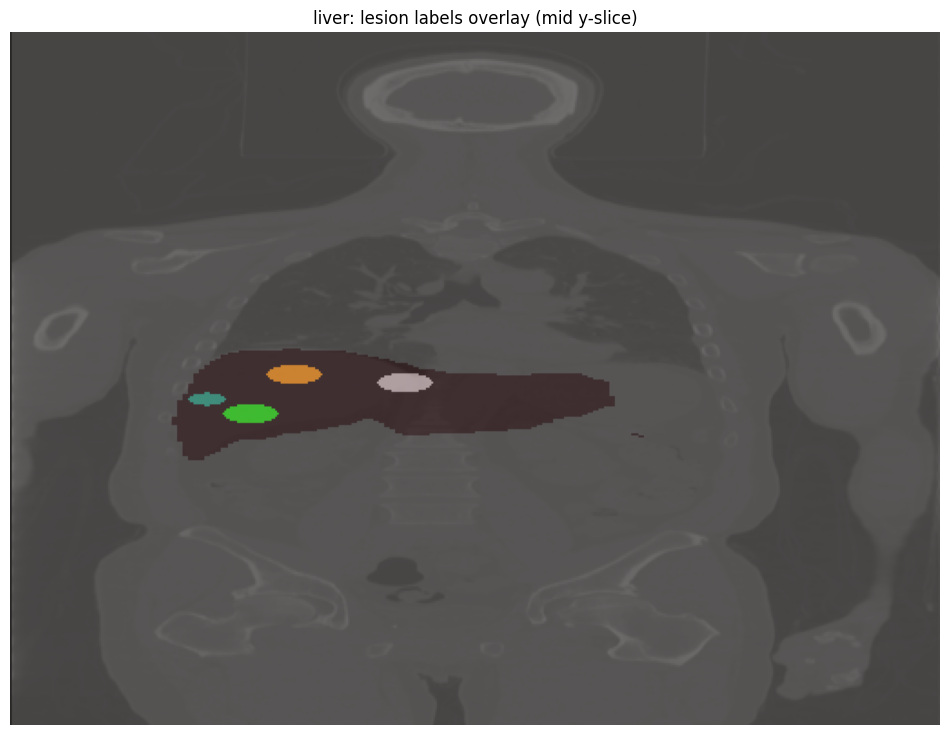

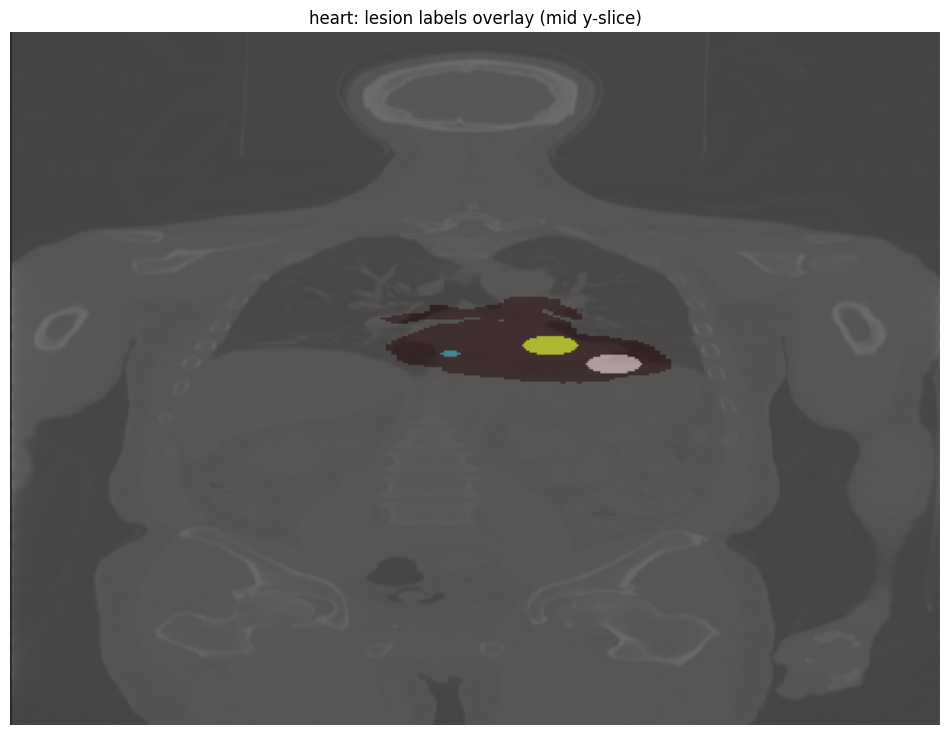

In [51]:
for roi in results:
    labelmap = results[roi]["labelmap"]
    m_img = results[roi]["ref_mask_img"]
    m = sitk_to_np(m_img) > 0

    mid_y = labelmap.shape[1] // 2

    plt.figure(figsize=(12,9))
    plt.imshow(ct[:, mid_y, :][::-1], cmap="gray")
    plt.imshow(np.max(m, axis=1)[::-1], cmap="Reds", alpha=0.35) # show organ mask in red
    plt.imshow((np.max(labelmap,axis=1)[::-1]), cmap="nipy_spectral", alpha=0.55, aspect = 'auto')
    plt.title(f"{roi}: lesion labels overlay (mid y-slice)")
    plt.axis("off")
    plt.show()

#### Save outputs (per ROI)

This gives you:
- {roi}_lesions_labels.nii.gz (multi-label 1..N)
- {roi}_lesions_binary.nii.gz (all lesions = 1)

In [ ]:
for roi, out in results.items():
    roi_dir = os.path.join(lesions_outdir, roi)
    os.makedirs(roi_dir, exist_ok=True)

    ref = out["ref_mask_img"]

    labels_img = np_to_sitk(out["labelmap"], ref, pixel_id=sitk.sitkInt16)
    binary_img = np_to_sitk(out["binary"], ref, pixel_id=sitk.sitkUInt8)
    organ_minus_img = np_to_sitk(out["organ_minus_lesions"], ref, pixel_id=sitk.sitkUInt8)

    sitk.WriteImage(labels_img, os.path.join(roi_dir, f"{roi}_lesions_labels.nii.gz"))
    sitk.WriteImage(binary_img, os.path.join(roi_dir, f"{roi}_lesions_binary.nii.gz"))
    sitk.WriteImage(organ_minus_img, os.path.join(roi_dir, f"{roi}_organ_minus_lesions.nii.gz"))

print("Saved all lesion masks to:", lesions_outdir)